In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime

def get_timestamp() -> str:
    timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    return timestamp

get_timestamp()


from tensorflow_addons.optimizers import AdamW

In [2]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -qq captcha_images_v2.zip

In [3]:
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = set(sorted(list(characters)))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16
# Desired image dimensions
img_width = 200
img_height = 64
# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'y', 'p', 'g', '4', '8', '6', 'm', 'c', '2', '7', 'b', 'd', 'f', '3', 'e', '5', 'x', 'n', 'w'}


In [4]:
char2id = {}
id2char = {}
for i,x in enumerate(list(characters)):
    char2id[x] = i
    
print(char2id)
for i,x in enumerate(list(characters)):
    id2char[i] = x
    
# print(id2char)

def char_to_num(char):
    res=[]
    for c in char:
#         print(c)
        res.append(char2id[c])
    return res
char_to_num('pddff')


def num_to_char(num):
    res = []
    for n in num.numpy():
        if n in id2char.keys():
            res.append(id2char[n])
        else:
            res.append('?')
    return res

{'y': 0, 'p': 1, 'g': 2, '4': 3, '8': 4, '6': 5, 'm': 6, 'c': 7, '2': 8, '7': 9, 'b': 10, 'd': 11, 'f': 12, '3': 13, 'e': 14, '5': 15, 'x': 16, 'n': 17, 'w': 18}


In [5]:

# Mapping characters to integers
# char_to_num = layers.StringLookup(
#     vocabulary=list(characters), mask_token=None
# )

# # Mapping integers back to original characters
# num_to_char = layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Splitting data into training and validation sets
x_train, x_valid, c_train, c_valid = split_data(np.array(images), np.array(labels))

y_train=[]
for i in c_train:
    y_train.append(char_to_num(i))

y_train = np.array(y_train,dtype=np.int32)
y_valid=[]
for i in c_valid:
    y_valid.append(char_to_num(i))
y_valid = np.array(y_valid,dtype=np.int32)



In [6]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
#     img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
#     label = char_to_label(label)
#     label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) -1
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

[ 0 15 11  1  1]
['y', '5', 'd', 'p', 'p']
[ 9  4 14 14  7]
['7', '8', 'e', 'e', 'c']
[14  4  3 17  8]
['e', '8', '4', 'n', '2']
[17 15  7  6  9]
['n', '5', 'c', 'm', '7']
[17 17  1  3 14]
['n', 'n', 'p', '4', 'e']
[ 3  9  3 12 12]
['4', '7', '4', 'f', 'f']
[17 13 16  3  7]
['n', '3', 'x', '4', 'c']
[15 10  2  4 12]
['5', 'b', 'g', '8', 'f']
[16  7  6 10  1]
['x', 'c', 'm', 'b', 'p']
[ 3  7  4 17  4]
['4', 'c', '8', 'n', '8']
[18  7  8 10 11]
['w', 'c', '2', 'b', 'd']
[17 16  7  6 17]
['n', 'x', 'c', 'm', 'n']
[11 17  8  0  6]
['d', 'n', '2', 'y', 'm']
[16 18 16  9 11]
['x', 'w', 'x', '7', 'd']
[ 6  5  9 10 13]
['m', '6', '7', 'b', '3']
[ 6 12  7 13 15]
['m', 'f', 'c', '3', '5']


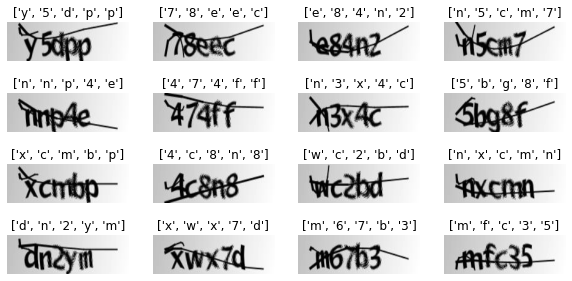

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i]).numpy().astype("float32")
#         print(labels[i])
        print(labels[i].numpy())
        label = num_to_char(labels[i])
        print(label)
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [9]:
config = {
#     "alpha": 1.0,
#     "minimalistic": True,
    "weights": "imagenet",
    "weights": None,
    "include_top": False
}
input_img = layers.Input(
    shape=(img_height,img_width, 1), name="image", dtype="float32"
#     shape=(img_width, img_height, 3), name="image", dtype="float32"
)
keras.applications.resnet50.ResNet50(input_tensor=input_img, **config).summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 206, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 100, 64)  3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 100, 64)  256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
config = {
#     "alpha": 1.0,
#     "minimalistic": True,
    "weights": "imagenet",
    "weights": None,
    "include_top": False
}
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_height,img_width, 3), name="image", dtype="float32"
#         shape=(200, 64, 3), name="image", dtype="float32"
    )
    # rescale = layers.Rescaling(scale=1.0 / 255,offset=0)(input_img)

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # x = keras.applications.vgg19.VGG19(include_top=False,weights='imagenet', input_tensor=input_img).get_layer('block2_pool').output
    # # base = keras.applications.MobileNetV3Large(input_tensor=input_img, **config).get_layer('Conv').output
    # x = keras.applications.ResNet101(include_top=False, weights='imagenet', input_tensor=input_img).get_layer('conv2_block1_out').output
#     x = keras.applications.MobileNetV3Large(input_tensor=input_img, **config).get_layer('expanded_conv/Add').output
    x  = keras.applications.resnet50.ResNet50(input_tensor=input_img, **config).get_layer('conv1_conv').output
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)
#     x = keras.layers.DepthwiseConv2D(32,(3,3),activation="relu",padding="same",kernel_initializer="he_normal")(x)

    # base = keras.applications.MobileNetV3Large(input_tensor=input_img,**config)
    # base = keras.applications.MobileNet(input_tensor=input_img, **config)

    # x = base.get_layer('Conv')(input_img)
    # x = base.get_layer('conv1').output
    

    # feature = base.get_layer('Conv').output

    # # First conv block
#     x = layers.Conv2D(
#         32,
#         (3, 3),
#         activation="relu",
#         kernel_initializer="he_normal",
#         padding="same",
#         name="Conv1",
#     )(x)
#     # x = layers.MaxPooling2D((2, 2), name="pool1")(x)

#     # # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
#     x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.MaxPooling2D((2, 2))(x)

    print(x)
    x = layers.Conv2D(32,(8,1),activation="relu",strides=1)(x)
    
    x = layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    # reshape
    # new_shape = ((img_width // 4), (img_height // 4) * 64)
    # x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # x = layers.Dense(64, activation="relu", name="dense1")(x)
    # x = layers.Dropout(0.2)(x)

    # RNNs
    # x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        20, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam(lr=0.0012, beta_1=0.9, beta_2=0.9, epsilon=1e-08, amsgrad=True) 
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 25, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 200, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 206, 3)   0           image[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 100, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
Conv2 (Conv2D)    

In [11]:

filepath = get_timestamp() + '.ckpt'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

epochs = 100
early_stopping_patience = 20
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint],
)


Epoch 1/100
59/59 [==============================] - 5s 74ms/step - loss: 26.5242 - val_loss: 16.6348

Epoch 00001: val_loss improved from inf to 16.63479, saving model to 2021_10_20_06_06_42.ckpt
Epoch 2/100
59/59 [==============================] - 4s 73ms/step - loss: 16.5269 - val_loss: 16.3242

Epoch 00002: val_loss improved from 16.63479 to 16.32420, saving model to 2021_10_20_06_06_42.ckpt
Epoch 3/100
59/59 [==============================] - 4s 70ms/step - loss: 16.2545 - val_loss: 16.3021

Epoch 00003: val_loss improved from 16.32420 to 16.30213, saving model to 2021_10_20_06_06_42.ckpt
Epoch 4/100
59/59 [==============================] - 4s 68ms/step - loss: 16.1804 - val_loss: 16.2314

Epoch 00004: val_loss improved from 16.30213 to 16.23140, saving model to 2021_10_20_06_06_42.ckpt
Epoch 5/100
59/59 [==============================] - 4s 65ms/step - loss: 16.0713 - val_loss: 15.9774

Epoch 00005: val_loss improved from 16.23140 to 15.97742, saving model to 2021_10_20_06_06_42.

KeyboardInterrupt: 

In [12]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, keras.layers.Softmax()(model.get_layer(name="dense2").output)
    # model.get_layer(name="image").input, model.get_layer(name="separable_conv2d_1").output
)
# prediction_model.summary()

(16, 64, 200, 3)


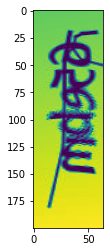

[13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.]
['65eb?', '2p2y?', 'w6xc?', 'x4p??', 'fxpw?', 'de45?', 'b35f?', 'gw4??', '5nmgn', 'geg??', 'm45??', '7dgc?', '5fye?', '2yg??', 'e6m6?', 'nmx8?']


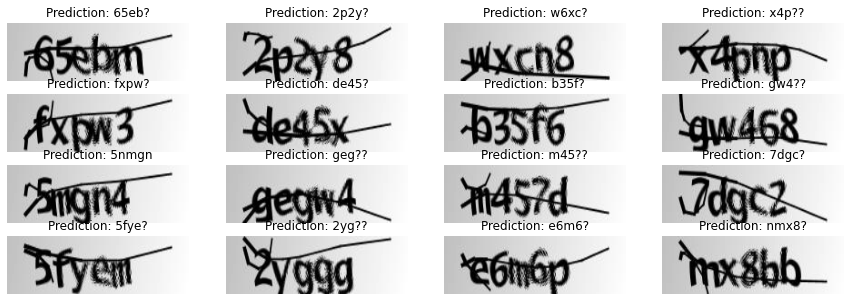

In [25]:
def decode_batch_predictions(pred):
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
    input_len = np.ones(pred.shape[0]) * 13
    # Use greedy search. For complex tasks, you can use beam search
    print(input_len)
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text





for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    plt.imshow(batch_images[0,...,0].numpy().T)
    plt.show()
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
#     print(pred.shape)
    print(pred_texts)
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [26]:
preds = prediction_model.predict(batch_images)
preds[0].shape
decode_batch_predictions(preds[0:1])

[13.]


['65eb?']

In [ ]:
img = batch_images.numpy()[0,...]
plt.imshow(img[...,0])
print(img.shape)
pred = prediction_model.predict(img[np.newaxis,::])
# print(pred)
input_len = [img.shape[0]//8]
print(input_len)

results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

num_to_char(tf.cast(results.numpy()[0],dtype=tf.int32))


In [ ]:
# workspace/dense.release/captcha_images_v2/22d5n.png
# workspace/dense.release/photo_2021-10-19_12-25-52.jpg
# workspace/dense.release/captcha_images_v2/yw667.png
img = tf.io.read_file('./captcha_images_v2/yw667.png')
# 2. Decode and convert to grayscale
img = tf.io.decode_png(img, channels=3)
# 3. Convert to float32 in [0, 1] range
img = tf.image.convert_image_dtype(img, tf.float32)
# 4. Resize to the desired size
img = tf.image.resize(img, [img_height, img_width])
# 5. Transpose the image because we want the time
# dimension to correspond to the width of the image.
img = tf.transpose(img, perm=[1, 0, 2])
# img = plt.imread('./photo_2021-10-19_12-25-52.jpg')
# img = plt.imread('./captcha_images_v2/22d5n.png')[...,0:3]

img_shape = img.shape
print(img_shape)
plt.imshow(img[...,0])
pred = prediction_model.predict(img[np.newaxis,::])

input_len = np.ones(pred.shape[0]) * pred.shape[1]
print(input_len)

results = keras.backend.ctc_decode(pred, input_length=[50], greedy=True)[0][0]
print(results)
num_to_char(tf.cast(results.numpy()[0],dtype=tf.int32)) 



In [ ]:
print(img_shape)
# w = tf.cast(HEIGHT / img_shape[0] * img_shape[1], tf.int64)
# img = tf.image.resize(img, (int(HEIGHT), 200), method=tf.image.ResizeMethod.AREA)
# img = tf.transpose(img,[1,0,2])
plt.imshow(img.numpy())
print(img.shape)


pred = prediction_model.predict(img[np.newaxis,::])
# print(pred)
print(pred.shape)
# input_len = img.shape[1] // 16
input_len = np.ones(pred.shape[0]) * pred.shape[1]
print(input_len)
# pred = np.squeeze(pred,axis=0)
print(pred.shape)
# decoded = keras.backend.ctc_decode(pred, input_length=[input_len])
esults = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
print(decoded)
text = "".join([id2char[x] for x in decoded[0][0].numpy()[0] if x != -1])
text